# LATAM Currencies vs Commodities Project Code

In [22]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import statsmodels
from statsmodels.tsa.stattools import coint
from sklearn.utils import resample
import seaborn as sns; sns.set()
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.odr import Model, Data, ODR
import statsmodels.api as sm
pd.options.mode.chained_assignment = None

Import Currency and Commodities Futures Data

In [4]:
read_excel_commodi = pd.ExcelFile('commodities_latam.xlsx')
x = read_excel_commodi.sheet_names
read_excel_currenc = pd.ExcelFile('latam_currencies.xlsx')
y = read_excel_currenc.sheet_names
exports_latam = pd.read_csv('gdp_latam.csv',index_col = 0)

commodities = []
currencies = []
for i in range(0,len(x)):
    commodities.append(pd.read_excel(read_excel_commodi, x[i], index_col=0))

for i in range(0,len(y)):
    currencies.append(pd.read_excel(read_excel_currenc, y[i],index_col=0))
df_commodities = pd.concat(commodities,axis=1, join='inner').dropna()
df_currencies = pd.concat(currencies,axis=1, join='inner').dropna()
df_total = pd.concat([df_commodities,df_currencies],axis=1, join='inner').dropna()

final_commodities = df_total.iloc[:,0:12]
final_currencies = df_total.iloc[:,12:18]
final_commodities.head()

,Copper/usd,Alum/usd,meat/usd,soybean/usd,crudeoil/usd,ironore/usd,corn/usd,sugar/usd,coffee/usd,wheat/usd,gold/usd,silver/usd
Dates,,,,,,,,,,,,
2013-10-21,330.35,1817.5,130.125,1303.25,99.22,980.0,444.00,511.9,137.40,699.75,1315.7,22.278
2013-10-22,333.55,1846.5,131.100,1302.25,97.80,967.0,438.25,513.8,136.20,700.75,1342.5,22.790
2013-10-23,326.75,1811.5,131.800,1310.00,96.86,956.0,442.75,509.0,135.00,701.75,1333.9,22.617
2013-10-24,326.35,1827.5,132.800,1309.75,97.11,938.0,440.25,502.3,134.85,696.50,1350.2,22.822
2013-10-25,326.90,1848.0,132.575,1300.00,97.85,935.0,440.00,503.3,134.25,690.75,1352.4,22.639


In [6]:
# Currencies are 1/value of the future meanning 1 BRL = 0.4601 USD
final_currencies.head()

,BRL/USD,CLP/USD,ARS/USD,MXN/USD,COP/USD,PEN/USD
Dates,,,,,,
2013-10-21,0.4601,0.19924,0.1709,0.07698,0.053070,0.361206
2013-10-22,0.4603,0.20047,0.1709,0.07787,0.053182,0.362911
2013-10-23,0.4587,0.19800,0.1706,0.07696,0.053110,0.362648
2013-10-24,0.4515,0.19847,0.1704,0.07711,0.053164,0.361141
2013-10-25,0.4571,0.19800,0.1700,0.07763,0.053121,0.362385


Plot Example of correlated movement between CLP and Copper

Text(0.5,1,'CLP vs Copper')

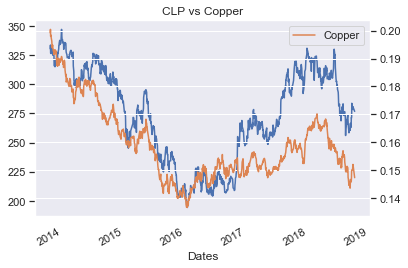

In [104]:
final_commodities['Copper/usd'].plot()
final_currencies['CLP/USD'].plot(secondary_y=True)
plt.legend(['Copper'])
plt.title('CLP vs Copper')

Correlation and Cointegration, with an example of the correlation heatmap

         Copper/usd  Alum/usd  meat/usd  soybean/usd  crudeoil/usd  \
BRL/USD    0.625490  0.100481  0.550938     0.825340      0.819324   
CLP/USD    0.818764  0.303092  0.391984     0.800606      0.881536   
ARS/USD    0.276251 -0.359330  0.756202     0.608009      0.529809   
MXN/USD    0.473387 -0.112579  0.763310     0.685703      0.744448   
COP/USD    0.648488  0.102872  0.611889     0.793956      0.897273   

         ironore/usd  corn/usd  sugar/usd  coffee/usd  wheat/usd  gold/usd  \
BRL/USD     0.764227  0.570602   0.276388    0.679714   0.655648  0.361627   
CLP/USD     0.799423  0.599667   0.051216    0.372031   0.695577  0.456167   
ARS/USD     0.564898  0.560646   0.128383    0.460366   0.694545 -0.143856   
MXN/USD     0.591114  0.610533   0.000108    0.557098   0.796508  0.044992   
COP/USD     0.741658  0.603060   0.122685    0.585763   0.758144  0.261604   

         silver/usd  
BRL/USD    0.775102  
CLP/USD    0.733418  
ARS/USD    0.463778  
MXN/USD    0.523751  


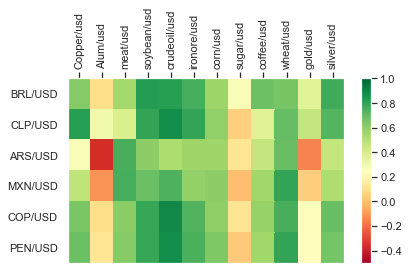

In [107]:
df_corr = pd.concat([final_currencies,final_commodities], axis=1).corr().filter(final_commodities.columns).filter(final_currencies.columns, axis=0)

corr_rows = df_corr.index.tolist()
corr_cols = df_corr.columns.tolist()
df_coint = pd.DataFrame(0, index=df_corr.index, columns=df_corr.columns)
for i in range(0,len(corr_rows)):
    for j in range(0,len(corr_cols)):
        df_coint.iloc[i,j] = coint(final_currencies.iloc[:,i].values,final_commodities.iloc[:,j].values)[0]

def visualize_data(x,lim):
    #df_corr = pd.concat([final_currencies,final_commodities], axis=1).corr().filter(final_commodities.columns).filter(final_currencies.columns, axis=0)
    print(x.head())
    #takes only data (numbers) inside the corr matrix
    data =  x.values
    fig = plt.figure()
    #1 by 1 in plot number one
    ax = fig.add_subplot(1,1,1)
    ax.set_xticks(np.arange(data.shape[1])+0.5,minor = False)
    ax.set_yticks(np.arange(data.shape[0])+0.5)
    #customizing the plot showing the correlation in color
    #if theres negative correlation if stock goes up other goes down
    heatmap = ax.pcolor(data,cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    #errases any gaps from the graph
    ax.invert_yaxis()
    #moves ticks from xaxis to the top
    ax.xaxis.tick_top()
    column_labels = x.columns
    row_labels = x.index
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    #limit of the color limit of the heatmap of correlationmatrix
    heatmap.set_clim(lim)
    plt.tight_layout()
    plt.show()
    
visualize_data(df_corr,[-0.5,1])

Ranking system to choose pairs to perform strategy

In [11]:
final_corr = df_corr.T.values.ravel('F')
final_coint = df_coint.T.values.ravel('F')
final_gdp = exports_latam.T.values.ravel('F')

tt = []
for i in range(0,len(corr_rows)):
    for j in range(0,len(corr_cols)):
        tt.append(corr_rows[i]+corr_cols[j])
        
final_col = ['Correlation','Cointegration','% Exports']
final_rankings_all = pd.DataFrame(0,index = tt,columns = final_col)
final_rankings_all['Correlation'] = final_corr
final_rankings_all['Cointegration'] = final_coint
final_rankings_all['% Exports'] = final_gdp

final_rankings_all = final_rankings_all.sort_values(by='Cointegration', ascending="False")
final_rankings_all.head()

,Correlation,Cointegration,% Exports
CLP/USDcoffee/usd,0.372031,-3.790705,0.000
BRL/USDcoffee/usd,0.679714,-3.699430,0.027
ARS/USDmeat/usd,0.756202,-3.500535,0.030
CLP/USDsoybean/usd,0.800606,-3.466197,0.000
CLP/USDironore/usd,0.799423,-3.346701,0.013


Pairs Chosen: CLP/soy beans, BRL/Coffee,ARS/Meat,CLP/ironore,clp/meat, cop/cofeem clp/cop, pen/coffee 


Data Processing and Cleaning, Total Least Square function and calculating residuals of pairs

In [30]:
clp = final_currencies['CLP/USD']
soy_beans = final_commodities['soybean/usd']
brl = final_currencies['BRL/USD']
coffee = final_commodities['coffee/usd']
ars = final_currencies['ARS/USD']
meat = final_commodities['meat/usd']
iron = final_commodities['ironore/usd']
copper = final_commodities['Copper/usd']
cop = final_currencies['COP/USD']
pen = final_currencies['PEN/USD']
mex = final_currencies['MXN/USD']

In [31]:
def linear_func(B, x):
    return B[0]*x+B[1]
def TLS(x,y):
    linear=Model(linear_func)
    linreg = stats.linregress(x,y)
    dat = Data(x,y)
    od = ODR(dat, linear, beta0=linreg[0:2])
    out = od.run()
    return out.beta[0]

Training Set Residuals (70% of data, 2014-2017)

beta_brlcoffee = TLS(coffee[:725],brl[:725])
beta_arsmeat = TLS(meat[:725],ars[:725])
beta_clpsoybean = TLS(soy_beans[:725],clp[:725])
beta_clpiron = TLS(iron[:725],clp[:725])
beta_clpmeat = TLS(meat[:725],clp[:725])
beta_copcoffee = TLS(coffee[:725],cop[:725])
beta_clpcopper = TLS(copper[:725],clp[:725])
beta_mexmeat = TLS(meat[:725],mex[:725])
beta_pencoffee = TLS(coffee[:725],pen[:725])

In [45]:
tt_res = ['BRL/USDcoffee/usd',
'ARS/USDmeat/usd',
'CLP/USDsoybean/usd',
'CLP/USDironore/usd',
'CLP/USDmeat/usd',
'COP/USDcoffee/usd',
'CLP/USDCopper/usd',
'MXN/USDmeat/usd',
'PEN/USDcoffee/usd']

residuals = pd.DataFrame(0, index=final_currencies[:725].index, columns=tt_res)
residuals['BRL/USDcoffee/usd'] = brl[:725] - coffee[:725]*beta_brlcoffee
residuals['ARS/USDmeat/usd'] = ars[:725] - meat[:725]*beta_arsmeat
residuals['CLP/USDsoybean/usd'] = clp[:725] - soy_beans[:725]*beta_clpsoybean
residuals['CLP/USDironore/usd'] = clp[:725] - iron[:725]*beta_clpiron
residuals['CLP/USDmeat/usd'] = clp[:725] - meat[:725]*beta_clpmeat
residuals['COP/USDcoffee/usd'] = cop[:725] - coffee[:725]*beta_copcoffee
residuals['CLP/USDCopper/usd'] = clp[:725] - copper[:725]*beta_clpcopper
residuals['MXN/USDmeat/usd'] = mex[:725] - meat[:725]*beta_mexmeat
residuals['PEN/USDcoffee/usd'] = pen[:725] - coffee[:725]*beta_pencoffee

Residual CLP vs Copper Plot with +,- 1 std and +,- 2 std

Text(0.5,1,'Residuals CLP vs Copper')

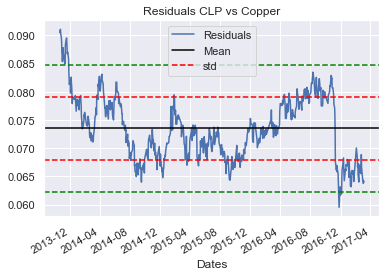

In [70]:
ratio = residuals['CLP/USDCopper/usd']
ratio.plot()
plt.axhline(ratio.mean(),color = 'black')
plt.axhline(ratio.mean()+np.std(ratio), color='red',linestyle='--')
plt.axhline(ratio.mean()-np.std(ratio), color='red',linestyle='--')
plt.axhline(ratio.mean()+2*np.std(ratio), color='green',linestyle='--')
plt.axhline(ratio.mean()-2*np.std(ratio), color='green',linestyle='--')
plt.legend(['Residuals','Mean','std'])
plt.title('Residuals CLP vs Copper')

Implement Pair Trading Strategy function with outputs of returns, sharpe ratio, maximum drawdowns, number of trades and hit ratios

In [35]:
def backtest(residuals,window):
    df1 = pd.DataFrame({'y':residuals}) 
    df1['spread'] = residuals
    
    # select window
    halflife = window
    
    #mean and std
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    
    ##############################################################
    # trading logic
    entryLong = meanSpread - stdSpread
    entryShort = meanSpread + stdSpread
    
    #set up num units long
    df1['long entry'] = (df1.spread > entryLong) &  (df1.spread < meanSpread)
    df1['long exit'] = (df1.spread >= meanSpread) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    #set up num units short 
    df1['short entry'] = (df1.spread < entryShort) &  (df1.spread > meanSpread)
    df1['short exit'] = (df1.spread <= meanSpread) 
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread']-df1['spread'].shift(1)) / df1['spread']
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    
    try:
        sharpe = (df1['port rets'].mean() / df1['port rets'].std()) *np.sqrt(252)
    except ZeroDivisionError:
        sharpe = 0.0
      
    maximums = np.maximum.accumulate(df1['cum rets'].dropna().values)
    drawdowns = 1 - (df1['cum rets'].dropna().values) / maximums
    max_drawdowns = np.amax(drawdowns)*100
    
    counters = 0
    for i in range(1, len(df1['numUnits'])):
        if (df1['numUnits'].iloc[i-1] != 0)& (df1['numUnits'].iloc[i] != df1['numUnits'].iloc[i-1]):
            counters += 1
    
    df1['hitratio'] = ""
    for i in range(1, len(df1['cum rets'])):
        if df1['cum rets'].iloc[i] > df1['cum rets'].iloc[i-1]:
            df1['hitratio'].iloc[i] = 'yes'
        if df1['cum rets'].iloc[i] < df1['cum rets'].iloc[i-1]:
            df1['hitratio'].iloc[i] = 'no'
    
    hit_ratio = (df1.hitratio.str.count("yes").sum()/(df1.hitratio.str.count("no").sum()+df1.hitratio.str.count("yes").sum()))*100
    
    return df1['cum rets'], sharpe , max_drawdowns, counters ,hit_ratio

Training output tables and values

In [41]:
tt_res_col = ['Total Returns %','Sharpe Ratio','Maximum Drawdown %','Number of Trades','Hit Ratio %']
train_df = pd.DataFrame(0, index=tt_res_col, columns=tt_res)
q_train = []
for i in range(0,9):
    q_train.append(backtest(residuals.iloc[:,i],65))
    
for i in range(0,9):
    train_df.iloc[0,i] = q_train[i][0][-1]
    train_df.iloc[1,i] = q_train[i][1]
    train_df.iloc[2,i] = q_train[i][2]
    train_df.iloc[3,i] = q_train[i][3]
    train_df.iloc[4,i] = q_train[i][4]

train_df.iloc[0,:] = (train_df.iloc[0,:] - 1)*100

train_df.T

,Total Returns %,Sharpe Ratio,Maximum Drawdown %,Number of Trades,Hit Ratio %
BRL/USDcoffee/usd,-6.098215,-0.026592,62.035549,39.0,51.892744
ARS/USDmeat/usd,23.382187,0.093201,74.667365,26.0,52.739726
CLP/USDsoybean/usd,-13.029225,-0.192975,39.126950,32.0,51.200000
CLP/USDironore/usd,29.580480,0.466211,19.713403,63.0,50.304878
CLP/USDmeat/usd,9.105113,0.207815,31.964653,40.0,50.078989
COP/USDcoffee/usd,-44.914203,-0.248707,74.440976,37.0,49.606299
CLP/USDCopper/usd,95.350184,1.297006,15.761999,82.0,53.654743
MXN/USDmeat/usd,-549.428707,-0.254764,838.168736,37.0,49.120000
PEN/USDcoffee/usd,-2.694122,-0.081357,14.889446,43.0,49.840764


Cumulative Return Plot of the 9 pairs

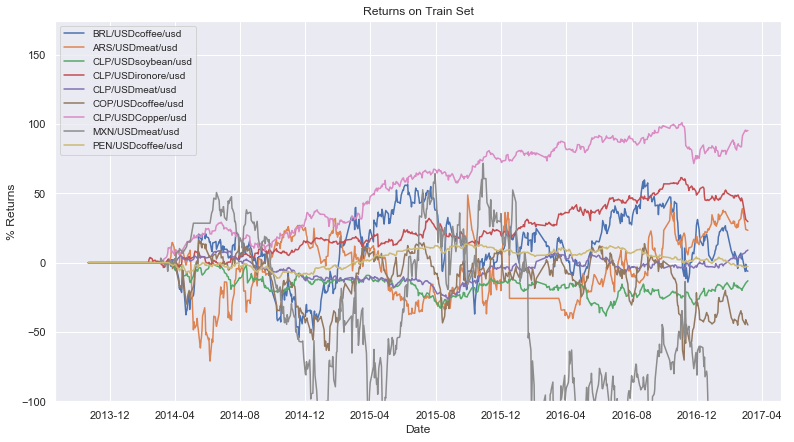

In [71]:
ret_train = pd.concat([q_train[0][0],q_train[1][0],q_train[2][0],q_train[3][0],
q_train[4][0],q_train[5][0],q_train[6][0],q_train[7][0],q_train[8][0]],axis = 1)
ret_train = (ret_train - 1)*100
ret_train.columns = ['BRL/USDcoffee/usd',
'ARS/USDmeat/usd',
'CLP/USDsoybean/usd',
'CLP/USDironore/usd',
'CLP/USDmeat/usd',
'COP/USDcoffee/usd',
'CLP/USDCopper/usd',
'MXN/USDmeat/usd',
'PEN/USDcoffee/usd']
plt.figure(figsize=(13,7))
plt.plot(ret_train)
plt.ylim(-100)
plt.ylabel('% Returns')
plt.xlabel('Date')
plt.title("Returns on Train Set")
plt.legend(ret_train.columns.values,prop={'size': 10})

Now apply the strategy for the test set of the 30% remaining data. In this case we only use the three best performing pairs and see how they would perform in the real world. I used the same betas from the previous training strategy, with the same moving window of 65 days. I invested a hypothetical 1 million dollar investment between these three pairs where I invested 80% into CLP/copper and the remaining 20% between CLP/Meat and CLP/Iron ore. The code shows the data processing, residuals and final performance of the portfolio.

In [58]:
tt_res_test = ['CLP/USDironore/usd',
'CLP/USDmeat/usd',
'CLP/USDCopper/usd']

residuals_test = pd.DataFrame(0, index=final_currencies[725:].index, columns=tt_res_test)
residuals_test['CLP/USDironore/usd'] = clp[725:] - iron[725:]*beta_clpiron
residuals_test['CLP/USDmeat/usd'] = clp[725:] - meat[725:]*beta_clpmeat
residuals_test['CLP/USDCopper/usd'] = clp[725:] - copper[725:]*beta_clpcopper

In [59]:
q_test = []

for i in range(0,3):
    q_test.append(backtest(residuals_test.iloc[:,i],65))

        
test_df = pd.DataFrame(0, index=tt_res_col, columns=tt_res_test)
for i in range(0,3):
    test_df.iloc[0,i] = q_test[i][0][-1]
    test_df.iloc[1,i] = q_test[i][1]
    test_df.iloc[2,i] = q_test[i][2]
    test_df.iloc[3,i] = q_test[i][3]
    test_df.iloc[4,i] = q_test[i][4]
    
test_df.iloc[0,:] = (test_df.iloc[0,:] - 1)*100
test_df.T

,Total Returns %,Sharpe Ratio,Maximum Drawdown %,Number of Trades,Hit Ratio %
CLP/USDironore/usd,7.862755,0.299183,15.954462,17.0,48.828125
CLP/USDmeat/usd,-20.012205,-1.067169,21.971651,7.0,46.478873
CLP/USDCopper/usd,11.788348,0.287109,21.141997,20.0,53.928571


Plot of the total return of the portfolio of the three pairs

Text(0.5,1,'Returns on Test Strategy with a 1 million starting investment')

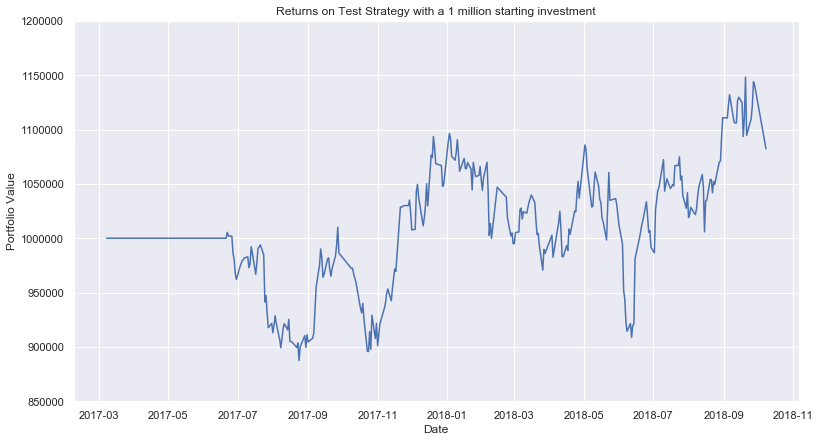

In [96]:
ret_test = [q_test[0][0],q_test[1][0],q_test[2][0]]
cum_ret_test = (ret_test[0])*100000 + (ret_test[1])*100000 +(ret_test[2])*800000
plt.figure(figsize=(13,7))
plt.plot(cum_ret_test)
plt.ylabel('Portfolio Value')
plt.xlabel('Date')
plt.ylim((850000,1200000))
plt.title("Returns on Test Strategy with a 1 million starting investment")

Total portfolio performance measures of the test period

In [102]:
test_final = test_df.T

portfolio_returns = test_final.iloc[0,:]*0.1 + test_final.iloc[1,:]*0.1 + test_final.iloc[2,:]*0.8
print('Total Portfolio Returns')
print('')
print(portfolio_returns)
print('')
print('Gain on Investment (dollars)',cum_ret_test[-1]-1000000)

Total Portfolio Returns

Total Returns %        8.215733
Sharpe Ratio           0.152888
Maximum Drawdown %    20.706209
Number of Trades      18.400000
Hit Ratio %           52.673557
dtype: float64

Gain on Investment (dollars) 82157.3342263014


**BONUS: residual graph with train and test set together of CLP/copper for the whole data set

Text(0.5,1,'Residuals CLP vs Copper')

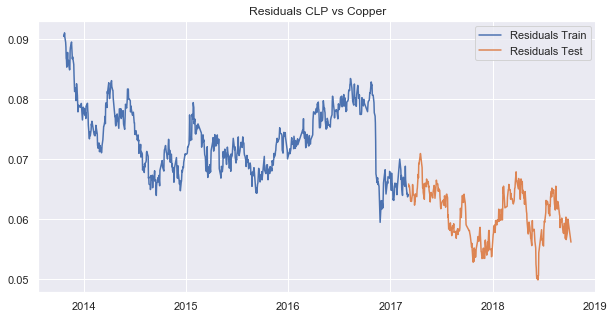

In [103]:
plt.figure(figsize=(10,5))
plt.plot(residuals['CLP/USDCopper/usd'])
plt.plot(residuals_test['CLP/USDCopper/usd'])
plt.legend(['Residuals Train','Residuals Test'])
plt.title('Residuals CLP vs Copper')